In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway, kruskal
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC, SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from gsmote import GeometricSMOTE

# Class Imbalance Analysis

In [3]:
# Read the training data
df = pd.read_csv('data/train.csv')

In [4]:
df.head(5)

,Gender,Age,Height,Weight,H_Cal_Consump,Veg_Consump,Water_Consump,Alcohol_Consump,Smoking,Meal_Count,Food_Between_Meals,Fam_Hist,H_Cal_Burn,Phys_Act,Time_E_Dev,Transport,Body_Level
0,Male,23.170309,1.707557,75.306702,yes,2.303367,1.277636,Sometimes,no,3.042774,Sometimes,yes,no,0.944982,0.366126,Public_Transportation,Body Level 3
1,Female,39.965474,1.739293,80.914382,yes,2.416044,1.352649,Sometimes,no,3.196043,Sometimes,no,no,0.148628,1.082660,Automobile,Body Level 3
2,Female,19.000000,1.650000,56.000000,yes,3.000000,3.000000,Frequently,yes,3.000000,Frequently,yes,yes,1.000000,2.000000,Public_Transportation,Body Level 2
3,Female,18.297229,1.637396,70.000000,yes,2.000000,2.326165,no,no,1.999014,Sometimes,yes,no,0.007050,0.000000,Public_Transportation,Body Level 3
4,Male,18.701766,1.704908,81.384224,yes,2.650629,1.708083,Sometimes,no,1.000000,Sometimes,yes,no,1.876051,0.938791,Public_Transportation,Body Level 3


In [5]:
# Display the count of every class in the dataset (Body_Level column)
df['Body_Level'].value_counts() / len(df)

Body Level 4    0.456922
Body Level 3    0.274927
Body Level 1    0.137464
Body Level 2    0.130687
Name: Body_Level, dtype: float64

#### It's clear that there is a large class imbalance in the data. Next is analyzing the relationship between Body_Level & the various other features as well as attempting to solve that imbalance using multiple techniques

#### First - Analyze the relationship between Body_Level & the other features

I'll perform the Chi-squared test, which is used to determine if there is a significant association between two categorical variables. I use this to check the association between the Body_Level (categorical) and each of the other categorical features

In [6]:
categorical_columns = ['Gender', 'H_Cal_Consump', 'Alcohol_Consump', 'Smoking',
                       'Food_Between_Meals', 'Fam_Hist', 'H_Cal_Burn', 'Transport']

for col in categorical_columns:
    contingency_table = pd.crosstab(df[col], df['Body_Level'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{col} vs Body_Level: p-value = {p:.4f}")

Gender vs Body_Level: p-value = 0.0013
H_Cal_Consump vs Body_Level: p-value = 0.0000
Alcohol_Consump vs Body_Level: p-value = 0.0000
Smoking vs Body_Level: p-value = 0.0015
Food_Between_Meals vs Body_Level: p-value = 0.0000
Fam_Hist vs Body_Level: p-value = 0.0000
H_Cal_Burn vs Body_Level: p-value = 0.0000
Transport vs Body_Level: p-value = 0.0000


From the result it's clear there is a statistical relationship between the Body_Level and each of the categorical features. Next, I use the Cramér’s V measure to see the strength of that relationship.

Cramér’s V is a measure of association between two categorical variables that ranges from 0 (no association) to 1 (perfect association).

In [7]:
# Calculate Cramér's V for pairs of categorical variables
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return (phi2corr / min((kcorr-1), (rcorr-1)))**0.5

for col in categorical_columns:
    v = cramers_v(df[col], df['Body_Level'])
    print(f"{col} vs Body_Level: Cramér's V = {v:.4f}")

Gender vs Body_Level: Cramér's V = 0.1112
H_Cal_Consump vs Body_Level: Cramér's V = 0.2939
Alcohol_Consump vs Body_Level: Cramér's V = 0.1205
Smoking vs Body_Level: Cramér's V = 0.1094
Food_Between_Meals vs Body_Level: Cramér's V = 0.3280
Fam_Hist vs Body_Level: Cramér's V = 0.4738
H_Cal_Burn vs Body_Level: Cramér's V = 0.2030
Transport vs Body_Level: Cramér's V = 0.1196


From the results we can see that the most related feature is Fam_Hist followed by Food_Between_meals & H_Cal_Consump. Also, all the other features are related to some extent but not by a large margin (around 0.1 to 0.15)

Now I'll check and see if there's a relationship between each of the numerical features & Body_Level. I can't just use correlation because the Body_Level is a categorical feature. So, I'll have to resort to 2 methods ANOVA (Analysis of Variance) or Kruskal-Wallis test to determine if there is a significant difference in the mean values of a numerical feature across different levels of Body_Level.

ANOVA is used to compare the means of a numerical variable across two or more groups.
Kruskal-Wallis test is a non-parametric alternative to ANOVA that can be used when the assumptions of normality and homogeneity of variance are not met.

This is similar to the chi-squared test in that they will output a p-value and if it's below 0.05, we reject the null hypothesis and conclude that there is a relationship between the features.

In [8]:
# List of numerical features
numerical_features = ['Age', 'Height', 'Weight', 'Veg_Consump', 'Water_Consump',
                      'Meal_Count', 'Phys_Act', 'Time_E_Dev']

# Perform a one-way ANOVA and a Kruskal-Wallis test for each numerical feature
for feature in numerical_features:
    f_stat, f_p_value = f_oneway(df[feature][df['Body_Level'] == 'Body Level 1'],
                                 df[feature][df['Body_Level'] == 'Body Level 2'],
                                 df[feature][df['Body_Level'] == 'Body Level 3'],
                                 df[feature][df['Body_Level'] == 'Body Level 4'])
    h_stat, h_p_value = kruskal(df[feature][df['Body_Level'] == 'Body Level 1'],
                                df[feature][df['Body_Level'] == 'Body Level 2'],
                                df[feature][df['Body_Level'] == 'Body Level 3'],
                                df[feature][df['Body_Level'] == 'Body Level 4'])
    print(f"{feature}: ANOVA p-value = {f_p_value:.4f}, Kruskal-Wallis p-value = {h_p_value:.4f}")

Age: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000
Height: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000
Weight: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000
Veg_Consump: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000
Water_Consump: ANOVA p-value = 0.0002, Kruskal-Wallis p-value = 0.0000
Meal_Count: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000
Phys_Act: ANOVA p-value = 0.0000, Kruskal-Wallis p-value = 0.0000
Time_E_Dev: ANOVA p-value = 0.0015, Kruskal-Wallis p-value = 0.0027


The results suggest that there is a relationship between each of the numerical features & the Body_Level. I'll do this in two ways. First, converting the Body_Level to a numerical feature & calculating the correlation between them.

Below I use two correlation coefficients: pearson & spearman. Pearson correlation coefficient measures the linear relationship between two variables, while Spearman correlation coefficient measures the monotonic relationship between two variables.

Pearson is more appropriate if the data is normally distributed, otherwise Spearman is better. I use both.

In [9]:
body_level_map = {'Body Level 1': 1, 'Body Level 2': 2, 'Body Level 3': 3, 'Body Level 4': 4}
df['Body_Level_Num'] = df['Body_Level'].map(body_level_map)

for feature in numerical_features:
    corr = df[[feature, 'Body_Level_Num']].corr(method='pearson') # or method='spearman'
    print(f"{feature}: correlation with Body_Level = {corr.iloc[0,1]:.4f}")

Age: correlation with Body_Level = 0.3355
Height: correlation with Body_Level = 0.1082
Weight: correlation with Body_Level = 0.8374
Veg_Consump: correlation with Body_Level = 0.0936
Water_Consump: correlation with Body_Level = 0.1249
Meal_Count: correlation with Body_Level = -0.0993
Phys_Act: correlation with Body_Level = -0.1699
Time_E_Dev: correlation with Body_Level = -0.1206


In [10]:
for feature in numerical_features:
    corr = df[[feature, 'Body_Level_Num']].corr(method='spearman') # or method='pearson'
    print(f"{feature}: correlation with Body_Level = {corr.iloc[0,1]:.4f}")

Age: correlation with Body_Level = 0.4095
Height: correlation with Body_Level = 0.1255
Weight: correlation with Body_Level = 0.8805
Veg_Consump: correlation with Body_Level = 0.1227
Water_Consump: correlation with Body_Level = 0.1439
Meal_Count: correlation with Body_Level = -0.1589
Phys_Act: correlation with Body_Level = -0.1555
Time_E_Dev: correlation with Body_Level = -0.1046


From the results, Weight has the strongest positive correlation (nearly 0.9) while the next best is Age (0.4). Phys_Act has the strongest negative correlation (-0.15).

To confirm my results, I'll draw scatter plots for the Body_Level against the 2 best features (Weight & Age)

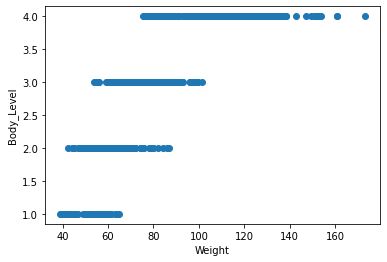

In [11]:
plt.scatter(df['Weight'], df['Body_Level_Num'])
plt.xlabel('Weight')
plt.ylabel('Body_Level')
plt.show()

In [12]:
# Show, the min, max, mean, median, and standard deviation of the weight for each body level
df.groupby('Body_Level')['Weight'].describe()

,count,mean,std,min,25%,50%,75%,max
Body_Level,,,,,,,,
Body Level 1,142.0,50.858330,6.262851,39.000000,45.452209,50.161731,54.994965,65.000000
Body Level 2,135.0,61.472593,9.901865,42.300000,53.000000,60.000000,68.500000,87.000000
Body Level 3,284.0,77.978903,9.365077,53.620604,70.000000,79.257263,85.000000,101.544589
Body Level 4,472.0,109.081861,17.293094,75.410647,99.512744,109.619180,120.257223,173.000000


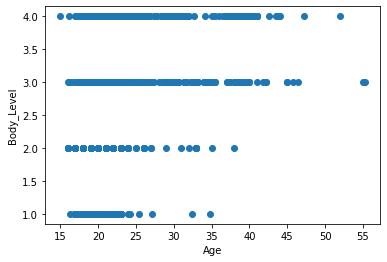

In [13]:
plt.scatter(df['Age'], df['Body_Level_Num'])
plt.xlabel('Age')
plt.ylabel('Body_Level')
plt.show()

In [14]:
df.groupby('Body_Level')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Body_Level,,,,,,,,
Body Level 1,142.0,19.886904,2.631357,16.30687,18.000000,19.240360,21.305180,34.799519
Body Level 2,135.0,21.437037,4.144061,16.00000,19.000000,21.000000,23.000000,38.000000
Body Level 3,284.0,25.264562,7.558896,16.00000,19.793775,22.292333,29.939898,55.246250
Body Level 4,472.0,25.808619,6.061085,15.00000,21.635247,25.132013,27.414154,52.000000


From the results, it's clear that the visualizations as well as the statistics conform with the results from the correlation values. There is a clear correlation between the Weight & Body_Level (consistent increase in the mean values of the Weight moving through body levels). The same also applies to the Age feature but to a lesser degree (as shown by the correlation results) as the mean barely increases going from Body_Level 3 to Body_Level 4

### Now with all the information I have about the relationship between features, I'll attempt to solve the class imbalance problem once not taking into account the correlation between features that I just calculated and another while taking into account that correlation

I'll be using two methods, one is resampling & the other is synthetic data generation

In [27]:
# Oversampling
ros = RandomOverSampler(random_state=0)
X_over_sampled_no_relationship, y_over_sampled_no_relationship = ros.fit_resample(df.drop(['Body_Level', 'Body_Level_Num'], axis=1), df['Body_Level'])

# Undersampling
rus = RandomUnderSampler(random_state=0)
X_under_sampled_no_relationship, y_under_sampled_no_relationship = rus.fit_resample(df.drop(['Body_Level', 'Body_Level_Num'], axis=1), df['Body_Level'])

# Save the oversampled and undersampled data
pd.DataFrame(X_over_sampled_no_relationship).to_csv('data/class_Imbalance/X_over_sampled_no_relationship.csv', index=False)
pd.DataFrame(y_over_sampled_no_relationship).to_csv('data/class_Imbalance/y_over_sampled_no_relationship.csv', index=False)
pd.DataFrame(X_under_sampled_no_relationship).to_csv('data/class_Imbalance/X_under_sampled_no_relationship.csv', index=False)
pd.DataFrame(y_under_sampled_no_relationship).to_csv('data/class_Imbalance/y_under_sampled_no_relationship.csv', index=False)

In [28]:
categorical_features = ['Gender', 'H_Cal_Consump', 'Alcohol_Consump',
                         'Smoking', 'Food_Between_Meals', 'Fam_Hist',
                           'H_Cal_Burn', 'Phys_Act', 'Transport']

categorical_indices = [df.columns.get_loc(feature) for feature in categorical_features]
smotenc = SMOTENC(categorical_features=categorical_indices, random_state=0)

X_SMOTENC_no_relationship, y_SMOTENC_no_relationship = smotenc.fit_resample(df.drop(['Body_Level', 'Body_Level_Num'], axis=1), df['Body_Level_Num'])

# Save the SMOTE data
pd.DataFrame(X_SMOTENC_no_relationship).to_csv('data/class_Imbalance/X_SMOTENC_no_relationship.csv', index=False)
pd.DataFrame(y_SMOTENC_no_relationship).to_csv('data/class_Imbalance/y_SMOTENC_no_relationship.csv', index=False)

In [30]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Encode categorical features
df_encoded = df.copy()
categorical_features = ['Gender', 'H_Cal_Consump',
                         'Alcohol_Consump', 'Smoking',
                           'Food_Between_Meals', 'Fam_Hist',
                             'H_Cal_Burn', 'Phys_Act', 'Transport']
for feature in categorical_features:
    le = LabelEncoder()
    df_encoded[feature] = le.fit_transform(df_encoded[feature])

# Use a feature selection method to assign importance scores to each feature
selector = SelectKBest(f_classif, k='all')
X_new = selector.fit_transform(df_encoded.drop(['Body_Level', 'Body_Level_Num'], axis=1), df_encoded['Body_Level_Num'])
importance_scores = selector.scores_

# Use the importance scores to guide the synthetic data generation process
smote = SMOTE(random_state=0, sampling_strategy={level: int(np.mean([importance_scores[df.columns.get_loc(feature)] for feature in ['Weight', 'Age', 'Fam_Hist']]) * count) for level, count in zip(*np.unique(df['Body_Level_Num'], return_counts=True))})
X_SMOTE_with_importance, Y_SMOTE_with_importance = smote.fit_resample(df_encoded.drop(['Body_Level', 'Body_Level_Num'], axis=1), df_encoded['Body_Level_Num'])

# Save the SMOTE data
pd.DataFrame(X_SMOTE_with_importance).to_csv('data/class_Imbalance/X_SMOTE_with_importance.csv', index=False)
pd.DataFrame(Y_SMOTE_with_importance).to_csv('data/class_Imbalance/y_SMOTE_with_importance.csv', index=False)

/home/jimbo/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (53419) in class 1 will be larger than the number of samples in the majority class (class #4 -> 472)
  warnings.warn(
/home/jimbo/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (50786) in class 2 will be larger than the number of samples in the majority class (class #4 -> 472)
  warnings.warn(
/home/jimbo/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (106839) in class 3 will be larger than the number of samples in the majority class (class #4 -> 472)
  warnings.warn(
/home/jimbo/.local/lib/python3.8/site-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (177564) in class 4 will be larger than the number of samples in the majority class (class #4